<a href="https://colab.research.google.com/github/eduardocoraca/ml_studies/blob/master/Transfer_Learning_ISIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Example

In this notebook, transfer learning is applied to the ISIC dataset, which consistes of images of skin lesion for classification.

## Loading data

Data is loaded from a Google Drive folder.



In [ ]:
!pip install PyDrive &> /dev/null

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1EH2tlRi4Iqq8WfLOXl6hMc5jTeiIRzaW"})
downloaded.GetContentFile('isic2017-trainval.zip')
!unzip -q isic2017-trainval.zip

downloaded = drive.CreateFile({'id':"1uP1tCj6-T2FXxk7g7gqoC_SGOhqIQyrM"})   
downloaded.GetContentFile('isic2017-test.zip')       
!unzip -q isic2017-test.zip

Classes '/benign' and '/malignant' are split in sub-folders, which enables the use of Keras ImageDataGenerator.

Creating the generators. Augmentation will be applied to the images, including rotation, shift, zoom and a preprocessing operation.

In [ ]:
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import random

random.seed(42)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
        rotation_range=90,
        width_shift_range=0.1,
        zoom_range=0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_generator = train_datagen.flow_from_directory(
        'isic2017-train/',
        target_size=(299, 299),
        batch_size=16,
        shuffle=True,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'isic2017-val/',
        target_size=(299, 299),
        batch_size=16,
        class_mode='categorical',
        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


## **1. Data Augmentation**

Plotting one image example:

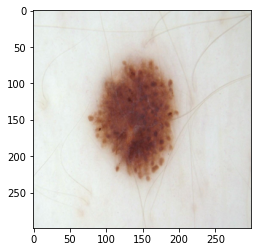

In [ ]:
from keras.preprocessing import image
import os

# Array containing benign class
fnames = [os.path.join('isic2017-train/benign', fname) for
  fname in os.listdir('isic2017-train/benign')]

exemplo_nome = fnames[2] # Choosing an image
exemplo = image.load_img(exemplo_nome)
plt.imshow(exemplo)
plt.savefig('lesao_original.eps', format='eps')

Plotting some augmented images:

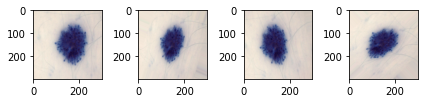

In [ ]:
exemplo_array = image.img_to_array(exemplo)
exemplo_array = exemplo_array.reshape((1,) + exemplo_array.shape)

i = 1
total_plots = 4
for batch in train_datagen.flow(exemplo_array, batch_size = 1):
  plt.subplot(1,total_plots,i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  plt.tight_layout()
  i = i + 1
  if i > total_plots:
    break

plt.tight_layout()
plt.savefig('Lesoes.eps', format='eps')

Computing class-weights:

In [ ]:
from sklearn.utils import class_weight
import numpy as np

arr_class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)
class_weights = dict(enumerate(arr_class_weights))

## **2. Baseline Model**

A simple Baseline Model is created and trained:

In [ ]:
epocas = 20
LOSS = tf.keras.losses.CategoricalCrossentropy()

In [ ]:
from tensorflow.keras import layers
from keras.layers.normalization import BatchNormalization

baseline = tf.keras.Sequential()

baseline.add(layers.Conv2D(10, 3, padding='valid', input_shape=(299, 299, 3)))
baseline.add(layers.BatchNormalization())
baseline.add(layers.Activation('relu'))
baseline.add(layers.MaxPooling2D(pool_size=(2,2)))

baseline.add(layers.Conv2D(10, 3, activation='relu', padding='valid'))
baseline.add(layers.BatchNormalization())
baseline.add(layers.Activation('relu'))
baseline.add(layers.MaxPooling2D(pool_size=(2,2)))

baseline.add(layers.Flatten())

baseline.add(layers.Dense(20, use_bias=False))
baseline.add(layers.BatchNormalization())
baseline.add(layers.Activation('relu'))

baseline.add(layers.Dense(2, activation='softmax'))

baseline.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 297, 297, 10)      280       
_________________________________________________________________
batch_normalization_37 (Batc (None, 297, 297, 10)      40        
_________________________________________________________________
activation_36 (Activation)   (None, 297, 297, 10)      0         
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 148, 148, 10)      0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 146, 146, 10)      910       
_________________________________________________________________
batch_normalization_38 (Batc (None, 146, 146, 10)      40        
_________________________________________________________________
activation_37 (Activation)   (None, 146, 146, 10)    

Training the model:

In [ ]:
baseline.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=LOSS)

baseline_history = baseline.fit(train_generator,                    
                                epochs=epocas,
                                validation_data=validation_generator,
                                class_weight=class_weights)

Epoch 1/20
125/125 [==============================] - 57s 454ms/step - loss: 0.7136 - val_loss: 0.7482
Epoch 2/20
125/125 [==============================] - 57s 452ms/step - loss: 0.6813 - val_loss: 0.6715
Epoch 3/20
125/125 [==============================] - 57s 452ms/step - loss: 0.6642 - val_loss: 0.6234
Epoch 4/20
125/125 [==============================] - 57s 452ms/step - loss: 0.6600 - val_loss: 0.6502
Epoch 5/20
125/125 [==============================] - 56s 451ms/step - loss: 0.6622 - val_loss: 0.6061
Epoch 6/20
125/125 [==============================] - 57s 453ms/step - loss: 0.6557 - val_loss: 0.6492
Epoch 7/20
125/125 [==============================] - 56s 447ms/step - loss: 0.6573 - val_loss: 0.5528
Epoch 8/20
125/125 [==============================] - 52s 417ms/step - loss: 0.6454 - val_loss: 0.6083
Epoch 9/20
125/125 [==============================] - 53s 420ms/step - loss: 0.6433 - val_loss: 0.5716
Epoch 10/20
125/125 [==============================] - 50s 404ms/step - l

Creating a function to plot training results:

In [ ]:
import re

def plotar_metricas(modelo, titulo):
  plt.plot(modelo.history['loss'])
  plt.plot(modelo.history['val_loss'])
  plt.legend(['Treino', 'Validação'])
  plt.ylabel('Loss')
  plt.xlabel('Épocas')

  plt.title(titulo)
  plt.gcf().subplots_adjust(bottom=0.15)
  figname = re.sub(' ', '_', titulo.lower())+'.eps'
  plt.savefig(figname, format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


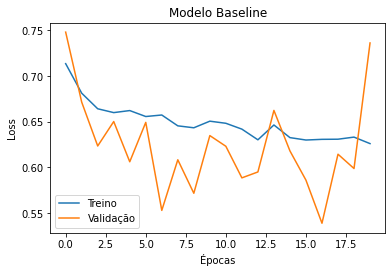

In [ ]:
plotar_metricas(baseline_history, "Modelo Baseline")

Creating a function to evaluate the trained model on test data, in terms of AUC:

In [ ]:
import sklearn.metrics

def avaliar(full_model, validation_generator):
  preds = full_model.predict(validation_generator)
  preds = np.argmax(preds, axis=1)

  batch_index = 0
  data_list = []
  while batch_index <= validation_generator.batch_index:
      _, label = validation_generator.next()
      data_list.extend(label)
      batch_index = batch_index + 1

  gt = np.argmax(data_list, axis=1)
  auc = sklearn.metrics.roc_auc_score(gt, preds)
  print("AUC:", auc)

In [ ]:
avaliar(baseline, validation_generator)

AUC: 0.6583333333333332


## **3. Transfer learning**

Choosing a pre-trained layer: (resnet50)

In [ ]:
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

Freezing convolutional layers and adding a new classification layer:

In [ ]:
from keras import regularizers

# Freezing layers
for layer in model.layers:
    layer.trainable = False

full_model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(20, use_bias=False),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

full_model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 10, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_59 (Dense)             (None, 20)                40960     
_________________________________________________________________
batch_normalization_40 (Batc (None, 20)                80        
_________________________________________________________________
activation_39 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 2)                 42        
Total params: 23,628,794
Trainable params: 41,042
Non-trainable params: 23,587,752
____________________________________

Training the model:

In [ ]:
full_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.CategoricalCrossentropy())

full_model_history = full_model.fit(train_generator,                    
                                epochs=epocas,
                                validation_data=validation_generator,
                                class_weight=class_weights)

Epoch 1/20
125/125 [==============================] - 64s 509ms/step - loss: 0.7538 - val_loss: 0.5005
Epoch 2/20
125/125 [==============================] - 63s 503ms/step - loss: 0.6347 - val_loss: 0.5593
Epoch 3/20
125/125 [==============================] - 63s 501ms/step - loss: 0.5936 - val_loss: 0.5836
Epoch 4/20
125/125 [==============================] - 63s 502ms/step - loss: 0.5806 - val_loss: 0.6094
Epoch 5/20
125/125 [==============================] - 62s 498ms/step - loss: 0.5634 - val_loss: 0.5917
Epoch 6/20
125/125 [==============================] - 62s 498ms/step - loss: 0.5408 - val_loss: 0.5274
Epoch 7/20
125/125 [==============================] - 62s 499ms/step - loss: 0.5363 - val_loss: 0.5012
Epoch 8/20
125/125 [==============================] - 60s 483ms/step - loss: 0.5335 - val_loss: 0.5039
Epoch 9/20
125/125 [==============================] - 60s 480ms/step - loss: 0.5193 - val_loss: 0.4923
Epoch 10/20
125/125 [==============================] - 60s 484ms/step - l

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


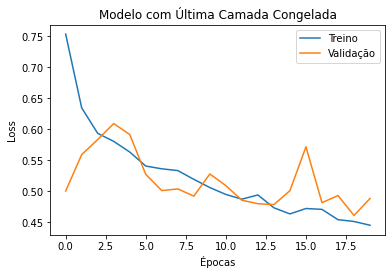

In [ ]:
plotar_metricas(full_model_history, "Modelo com Última Camada Congelada")

In [ ]:
avaliar(full_model, validation_generator) # on validation data

AUC: 0.6958333333333333


In [ ]:
avaliar(full_model, test_generator) # on test data

AUC: 0.6796995275256145


 ## **5. Fine-Tuning**

Un-freezing layers:

In [ ]:
for layer in model.layers:
    layer.trainable = True

full_model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 10, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_59 (Dense)             (None, 20)                40960     
_________________________________________________________________
batch_normalization_40 (Batc (None, 20)                80        
_________________________________________________________________
activation_39 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 2)                 42        
Total params: 23,628,794
Trainable params: 23,575,634
Non-trainable params: 53,160
____________________________________

In [ ]:
# Fine-tuning the model
full_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=LOSS)

full_model_history = full_model.fit(train_generator,                    
                                epochs=epocas,
                                validation_data=validation_generator,
                                class_weight=class_weights)

Epoch 1/20
125/125 [==============================] - 92s 735ms/step - loss: 0.5987 - val_loss: 0.4831
Epoch 2/20
125/125 [==============================] - 90s 720ms/step - loss: 0.5020 - val_loss: 0.4641
Epoch 3/20
125/125 [==============================] - 88s 705ms/step - loss: 0.4604 - val_loss: 0.5133
Epoch 4/20
125/125 [==============================] - 88s 705ms/step - loss: 0.4501 - val_loss: 0.4594
Epoch 5/20
125/125 [==============================] - 88s 704ms/step - loss: 0.4247 - val_loss: 0.4285
Epoch 6/20
125/125 [==============================] - 88s 703ms/step - loss: 0.3976 - val_loss: 0.4508
Epoch 7/20
125/125 [==============================] - 88s 703ms/step - loss: 0.3664 - val_loss: 0.4322
Epoch 8/20
125/125 [==============================] - 89s 710ms/step - loss: 0.3692 - val_loss: 0.3931
Epoch 9/20
125/125 [==============================] - 88s 704ms/step - loss: 0.3538 - val_loss: 0.3992
Epoch 10/20
125/125 [==============================] - 89s 714ms/step - l

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


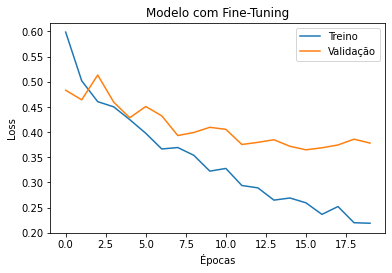

In [ ]:
plotar_metricas(full_model_history, "Modelo com Fine-Tuning")

In [ ]:
avaliar(full_model, validation_generator)

AUC: 0.6333333333333333


## **6. Evaluating the best model**

By looking at AUC values on the validation dataset, the best model was with Transfer Learning keeping Convolutional Layers frozen and training only the Fully Connected layer. 

AUC value on test dataset was: **0.6797**.
